# Quantile Regression for Differences

Attempt to use quantile regression for predicting one step ahead

A basic version that works is implemented in this notebook. Next steps are:

* [ ] Implement automated hyperparameter optimization. I've noticed hyperparameter tuning plays a major role in algorithm performance here. Would save time (and be a good thing to have moving forward) to implement hyperparameter tuning here
    * Possible frameworks:
        * https://scikit-learn.org/stable/modules/grid_search.html#searching-for-optimal-parameters-with-successive-halving
        * https://github.com/optuna/optuna
        * https://github.com/hyperopt/hyperopt
        * 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from monotonic import MonotonicQuantileRegressor
from qr_simulation import QuantileRegressionSimulator
from scipy.integrate import solve_ivp

plt.style.use("ggplot")


c:\Users\robert.robison\.virtualenvs\ar_forecasting\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gen Data

In [4]:

def pendulum_actual(t, state, p):
    # state = [theta, theta_d]

    # Parameters
    mu, L = p

    # Calc derivatives
    theta_d = state[1]
    theta_dd = 9.8 * np.sin(state[0]) / L - mu * state[1]

    return np.array([theta_d, theta_dd])

# Set initial conditions and parameters
tspan = (0, 20)
X0 = np.array([0.524, 0.0])  # 30 degrees, at rest
X0 = np.array([
    [0.524, 1.57, -1.0, -2.5, 0.0, -0.25],  # theta
    [0.0, -1.0, 1.0, 2.0, 0.5, 3.0],  # theta_d
])
p = [0.2, 1.0]

# solve ODE
t = np.linspace(*tspan, 100)
# res = solve_ivp(pendulum_actual, tspan, X0, args=[p], dense_output=True)
res_list = []
noise = 0.0
empty_row = pd.DataFrame({"theta": [np.nan], "theta_d": [np.nan]})
for i in range(X0.shape[1]):
    res = solve_ivp(pendulum_actual, tspan, X0[:, i], args=[p], dense_output=True)
    curr_data = pd.DataFrame(res.sol(t).T + noise * np.random.normal(size=(t.shape[0], 2)), columns=["theta", "theta_d"])
    res_list.append(curr_data)
    res_list.append(empty_row)
data = pd.concat(res_list)
data


,theta,theta_d
0,0.524000,0.000000
1,0.625569,1.026802
2,0.957781,2.331968
3,1.597754,4.056887
4,2.581251,5.513121
...,...,...
96,3.499190,-0.022624
97,3.427914,-0.655520
98,3.252308,-1.022093
99,3.042029,-0.989935


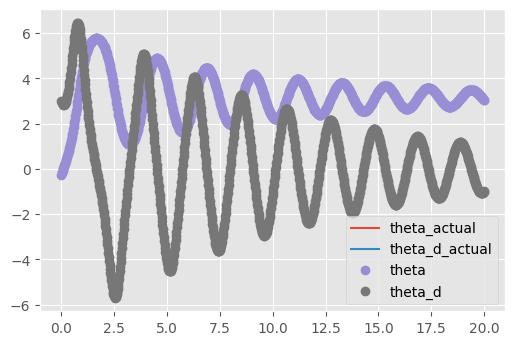

In [5]:
plt.style.use("ggplot")

all_t = np.linspace(*tspan, 1000)
fig, ax = plt.subplots(dpi=100)
pd.DataFrame(
    res.sol(all_t).T, index=all_t, columns=["theta_actual", "theta_d_actual"]
).plot(ax=ax)

t = np.linspace(*tspan, 1000)
data = pd.DataFrame(
    res.sol(t).T + 0.0 * np.random.normal(size=(t.shape[0], 2)),
    index=t,
    columns=["theta", "theta_d"],
)
data.plot(ax=ax, ls="", marker="o")

plt.show()


In [9]:
# Get theta_dd
# data["theta_dd"] = data.apply(lambda row: pendulum_actual(0, [row.theta, row.theta_d], p)[1], axis=1)


data

,theta,theta_d
0.000000,0.524000,0.000000
0.202020,0.625569,1.026802
0.404040,0.957781,2.331968
0.606061,1.597754,4.056887
0.808081,2.581251,5.513121
...,...,...
19.191919,3.203971,-0.948439
19.393939,3.016484,-0.845868
19.595960,2.883618,-0.428405
19.797980,2.852967,0.130496


## Model data

## Hyperparameter Optimization

In [7]:
qr = QuantileRegressionSimulator(
    data,
    m_factor=10,
    # sample=True,
    random_state=5,
    n_diff =1,
)
qr.train()


[I 2023-05-17 00:45:10,295] A new study created in memory with name: no-name-16ff095e-24d4-442a-905f-0cc4fc5dc063


Running hyperparameter tuning for model 1...


[I 2023-05-17 00:45:11,009] Trial 0 finished with value: 0.006584213451237395 and parameters: {'learning_rate': 0.1336812394688376, 'use_early_stopping': 0, 'early_stopping_round': 64, 'lambda_l1': 0.0019675670223257584, 'lambda_l2': 6.493028730377476e-08, 'num_leaves': 355, 'feature_fraction': 0.3338181837966496, 'min_child_samples': 16}. Best is trial 0 with value: 0.006584213451237395.
[I 2023-05-17 00:45:11,370] Trial 1 finished with value: 0.0070683705137295 and parameters: {'learning_rate': 0.15385774494982474, 'use_early_stopping': 1, 'early_stopping_round': 20, 'lambda_l1': 2.2323545394354185, 'lambda_l2': 0.004835543093518213, 'num_leaves': 483, 'feature_fraction': 0.1993162816159089, 'min_child_samples': 33}. Best is trial 0 with value: 0.006584213451237395.
[I 2023-05-17 00:45:11,716] Trial 2 finished with value: 0.008494083598752008 and parameters: {'learning_rate': 0.14275961627917047, 'use_early_stopping': 1, 'early_stopping_round': 69, 'lambda_l1': 0.0001021310048147263,

Number of finished trials: 100
Best trial:
  Value: 0.001811381099199996
  Params: 
    learning_rate: 0.023613136340367703
    use_early_stopping: 1
    early_stopping_round: 51
    lambda_l1: 1.1678975480458427e-08
    lambda_l2: 0.018736823431351395
    num_leaves: 172
    feature_fraction: 0.36080323525020414
    min_child_samples: 10
Running hyperparameter tuning for model 2...


[I 2023-05-17 00:45:36,899] Trial 0 finished with value: 0.004606763662922777 and parameters: {'learning_rate': 0.10257978222172799, 'use_early_stopping': 0, 'early_stopping_round': 7, 'lambda_l1': 3.495314107219128, 'lambda_l2': 3.626270788562424, 'num_leaves': 103, 'feature_fraction': 0.18701861419735108, 'min_child_samples': 13}. Best is trial 0 with value: 0.004606763662922777.
[I 2023-05-17 00:45:37,096] Trial 1 finished with value: 0.00598206201362218 and parameters: {'learning_rate': 0.1315360808270999, 'use_early_stopping': 1, 'early_stopping_round': 56, 'lambda_l1': 2.916880583928355e-08, 'lambda_l2': 7.579354412911197e-06, 'num_leaves': 79, 'feature_fraction': 0.13992718081066627, 'min_child_samples': 100}. Best is trial 0 with value: 0.004606763662922777.
[I 2023-05-17 00:45:37,405] Trial 2 finished with value: 0.005710930516356607 and parameters: {'learning_rate': 0.051222243889075945, 'use_early_stopping': 0, 'early_stopping_round': 44, 'lambda_l1': 7.780955523764285e-05, 

Number of finished trials: 100
Best trial:
  Value: 0.003547841202459199
  Params: 
    learning_rate: 0.058277972660663334
    use_early_stopping: 0
    early_stopping_round: 56
    lambda_l1: 0.00046384078982667415
    lambda_l2: 0.04251458725324142
    num_leaves: 357
    feature_fraction: 0.202794865500155
    min_child_samples: 29


,theta_0.2,theta_d_0.2
0.02002,0.038945,-0.075161
0.04004,0.041324,-0.058833
0.06006,0.035808,-0.042659
0.08008,0.038794,-0.047284
0.10010,0.034276,-0.035239


,theta_0.5,theta_d_0.5
0.02002,0.065860,-0.050028
0.04004,0.065617,-0.033700
0.06006,0.060913,-0.017526
0.08008,0.060410,-0.022151
0.10010,0.055891,-0.010106


,theta_0.8,theta_d_0.8
0.02002,0.084650,-0.026123
0.04004,0.084408,-0.009795
0.06006,0.074943,0.006379
0.08008,0.074440,0.001754
0.10010,0.069922,0.013799


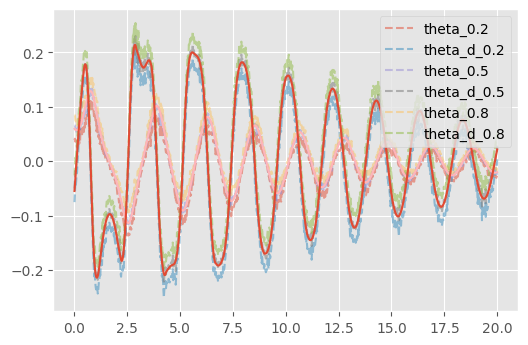

In [8]:
alpha = [0.2, 0.5, 0.8]
fig, ax = plt.subplots(dpi=100)
for a in alpha:
    pred = qr.predict(data.iloc[:len(t)], alpha=a)
    pred_df = pd.DataFrame(pred, columns=[f"{col}_{a}" for col in data.columns])
    # pred_df = pd.DataFrame(pred + data.to_numpy(), columns=[f"{col}_{a}" for col in data.columns])
    pred_df = pred_df.iloc[:-1]
    pred_df.index=t[1:]
    pred_df.plot(ax=ax, ls="--", alpha=0.5)
    display(pred_df.head())
ax.plot(t, (data - data.shift()).iloc[:len(t), 0])
ax.plot(t, (data - data.shift()).iloc[:len(t), 1])
plt.show()

In [9]:
nsims = 100
sims = np.zeros((nsims, len(t), data.shape[1]))
X0 = data.copy().iloc[0].to_numpy()
for i in range(nsims):
    sims[i, ...] = qr.simulate_path(data.iloc[0].to_numpy(), len(t), sample=True)
    

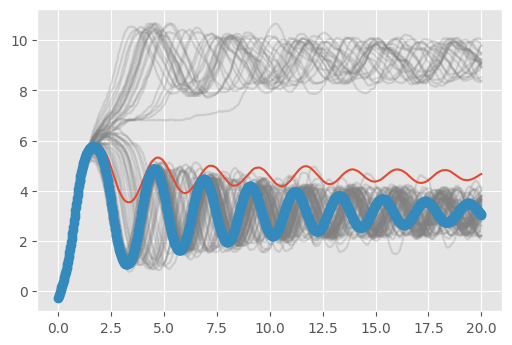

In [10]:

fig, ax = plt.subplots(dpi=100)
# alpha = [0.5, 0.8, 0.95, 0.995]
# for i, a in enumerate(reversed(sorted(alpha))):
#     a2 = (1 - a) / 2
#     ax.fill_between(all_t, y1=np.quantile(theta_sims, a2, axis=1), y2=np.quantile(theta_sims, 1 - a2, axis=1), alpha=0.25 * (i + 1), color="gray", label=alpha)
for i in range(nsims):
    ax.plot(t, sims[i, :, 0], label="", c="gray", alpha=0.25)
ax.plot(t, sims[:, :, 0].mean(axis=0), label="mean")
ax.plot(t, data.theta.iloc[:len(t)], ls="", marker="o")
# data.iloc[:len(t)].theta.plot(ax=ax, ls="", marker="o")
plt.show()


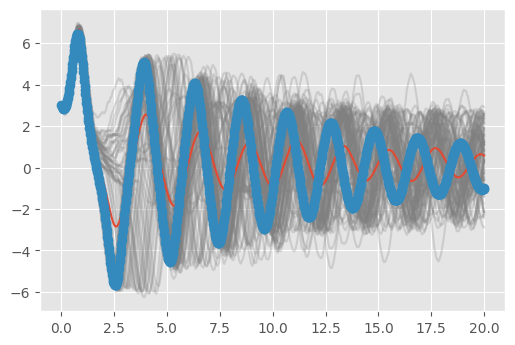

In [11]:

fig, ax = plt.subplots(dpi=100)
# alpha = [0.5, 0.8, 0.95, 0.995]
# for i, a in enumerate(reversed(sorted(alpha))):
#     a2 = (1 - a) / 2
#     ax.fill_between(all_t, y1=np.quantile(theta_sims, a2, axis=1), y2=np.quantile(theta_sims, 1 - a2, axis=1), alpha=0.25 * (i + 1), color="gray", label=alpha)
for i in range(nsims):
    ax.plot(t, sims[i, :, 1], label="", c="gray", alpha=0.25)
ax.plot(t, sims[:, :, 1].mean(axis=0), label="mean")
ax.plot(t, data.theta_d.iloc[:len(t)], ls="", marker="o")
# data.iloc[:len(t)].theta.plot(ax=ax, ls="", marker="o")
plt.show()


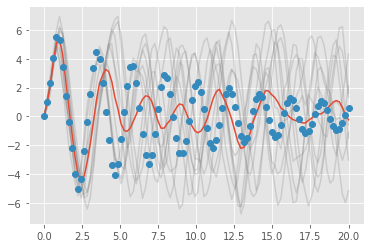

In [37]:


fig, ax = plt.subplots()
# alpha = [0.5, 0.8, 0.95, 0.995]
# for i, a in enumerate(reversed(sorted(alpha))):
#     a2 = (1 - a) / 2
#     ax.fill_between(all_t, y1=np.quantile(theta_sims, a2, axis=1), y2=np.quantile(theta_sims, 1 - a2, axis=1), alpha=0.25 * (i + 1), color="gray", label=alpha)
for i in range(nsims):
    ax.plot(data.index, sims[i, :, 1], label="", c="gray", alpha=0.25)
ax.plot(data.index, sims[:, :, 1].mean(axis=0), label="mean")
data.theta_d.plot(ax=ax, ls="", marker="o")
plt.show()


In [14]:
qr.models[0].best_iteration

-1

In [18]:
qr.models[1].params


{}

## github example

In [52]:
sample_size=500
alphas = [0.3, 0.4, 0.5, 0.6, 0.7]
x = np.linspace(-10, 10, sample_size).reshape(-1, 1)
x_test = np.linspace(-10, 10, sample_size).reshape(-1, 1)
y_noise = np.sin(x[:, 0]) + np.random.uniform(-0.4, 0.4, sample_size)
y_test = np.sin(x_test[:, 0]) + np.random.uniform(-0.4, 0.4, sample_size)
params = {
    "max_depth": 4,
    "num_leaves": 5,
    "learning_rate": 0.1,
    "n_estimators": 50,
    # "boosting_type": "gbdt",
}
monotonic_quantile_regressor = MonotonicQuantileRegressor(x=x, y=y_noise, m_factor=500)
model = monotonic_quantile_regressor.train(params=params)
preds = monotonic_quantile_regressor.predict(x=x_test, alphas=alphas)
preds_df = pd.DataFrame(preds)
(preds_df.diff(axis = 1) < 0).sum(axis = 1).sum(axis = 0)

c:\Users\robert.robison\.virtualenvs\ar_forecasting\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\robert.robison\.virtualenvs\ar_forecasting\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 250000, number of used features: 4
[LightGBM] [Warning] Using self-defined objective function


0

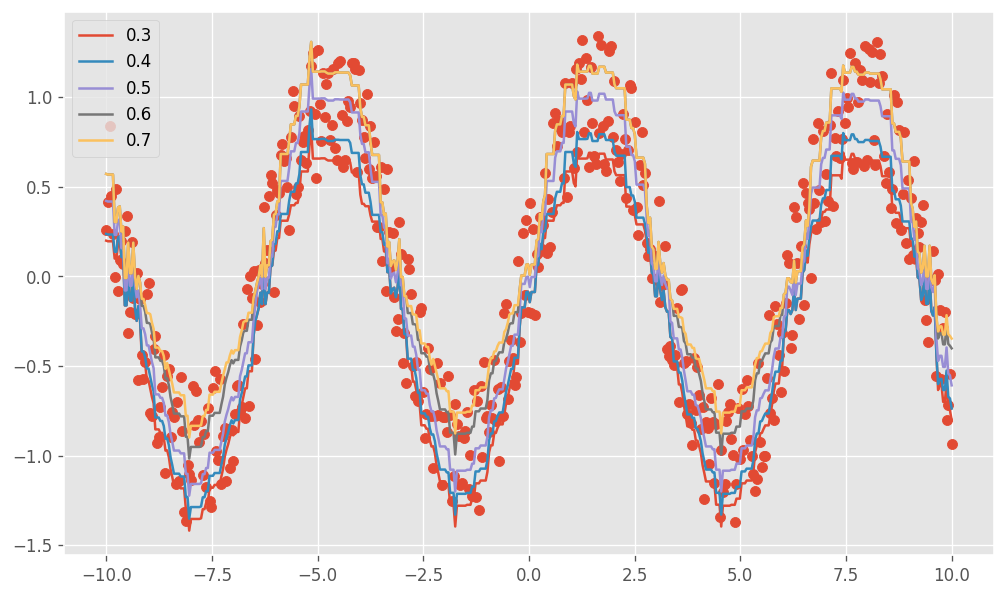

In [53]:
preds_df.columns = alphas
preds_df.index = x_test[:, 0]

fig, ax = plt.subplots(dpi=120, figsize=(10, 6))
ax.scatter(x_test[:, 0], y_test, label="Test data")
preds_df.plot(ax=ax)
plt.show()